In [1]:
import torchvision.models as torch_models
import os

from helper import *

In [2]:
path = Path('/home/jupyter/Kaggle/kaggle_grapheme')
TRAIN_LABELS = path/'data/train.csv'
TRAIN_IMG_FILES = path/'data/'

RES34_PRETRAIN = path/'models/resnet/res34-stage1-pretrained-712'

In [3]:
df_train = pd.read_csv(TRAIN_LABELS)

In [4]:
df_train.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [5]:
df_train.nunique()

image_id               200840
grapheme_root             168
vowel_diacritic            11
consonant_diacritic         7
grapheme                 1295
dtype: int64

In [5]:
tfms = get_transforms(do_flip=False,max_rotate=40.,max_warp=0.,xtra_tfms=[cutout(p=0.5)]) # updated argumentation 
stats = ([0.0692], [0.2051])
bs = 128

In [6]:
data = (ImageList
        .from_df(df_train,path=TRAIN_IMG_FILES,cols=0,convert_mode='L',suffix='.png')
        .split_by_rand_pct(seed=42)
        .label_from_df(cols=['grapheme_root','vowel_diacritic','consonant_diacritic'])
        .transform(tfms,size=(128,128),padding_mode='zeros')
        .databunch(bs=bs,num_workers=os.cpu_count()*4)
        .normalize(stats)
       )

In [11]:
#data.show_batch(rows=3,figsize=(12,12))

In [7]:
#Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
#https://arxiv.org/abs/1908.08681v1
#implemented for PyTorch / FastAI by lessw2020 
#github: https://github.com/lessw2020/mish
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x * (torch.tanh(F.softplus(x)))

# Model 

1. Change the input conv_2d to take 1 channel grey scale image
2. Transfer learning, copy first conv_2d weights to the new conv2d, aggregate 3 channel weights as suggested from stackoverflow / pytorch forum posts. (Note: Divide by 3 '(R+G+B)/3' does not have a effect if you think about back propogation, constant are just 1 ? However, I am not sure about the math)
3. Multi - head: 

1. Inspired by APTOS and Retina net, it should be possible to output multi-results from the same backbone
2. As suggested by DrHB https://www.kaggle.com/c/bengaliai-cv19/discussion/123432, the additional conv2d layer is to give each head a possibility to update weights before pooling
3. Used AdaptiveConcatpool and standard fastai head structure
4. Used Mish activatation function instead of ReLU

In [8]:
class Model_Head(nn.Module):
    def __init__(self,ni,nc,ps=0.25):
        '''
        ni : input filter size
        nc : output class size
        ps : dropout rate
        '''
        super().__init__()
        layers = ([Mish(),conv2d(ni,ni),batchnorm_2d(ni),AdaptiveConcatPool2d(),Flatten()] 
                  + bn_drop_lin(ni*2,512,p=ps,actn=Mish()) 
                  + bn_drop_lin(512,nc,p=ps*2))
        self.head = nn.Sequential(*layers)
    
    def forward(self,xb):
        return self.head(xb)
    
class Resnet_1ch(nn.Module):
    def __init__(self,arch,nc=[168,11,7],pretrained=True):
        super().__init__()
        self.body = nn.Sequential(*list(arch(pretrained=pretrained).children())[:-2])
       
        # change input filter size to 1
        nf,ni,h,w = self.body[0].weight.shape
        w = self.body[0].weight.sum(dim=1,keepdim=True)
        conv_input = conv2d(1,nf,ks=h)
        conv_input.weight.data = w
        self.body[0] = conv_input
        
        # multi-head output
        # 168,11,7 from num of unique labels
        ni = num_features_model(self.body)
        self.head_grapheme = Model_Head(ni,nc[0])
        self.head_vowel = Model_Head(ni,nc[1])
        self.head_consonant = Model_Head(ni,nc[2])
    
    def forward(self,x):
        x = self.body(x)
        return (self.head_grapheme(x),self.head_vowel(x),self.head_consonant(x))
    
# replace all relu layer with Mish        
def to_mish(model):
    for name,child in model.named_children():
        if isinstance(child,nn.ReLU):
            setattr(model,name,Mish())
        else:
            to_mish(child)

In [9]:
class Loss_multi_head(nn.Module):
    def __init__(self,weights=[1,1,1]):
        super().__init__()
        self.weights = weights
        
    def forward(self,preds,target,reduction='mean'):
        outp_1,outp_2,outp_3 = preds
        outp_1,outp_2,outp_3 = outp_1.float(),outp_2.float(),outp_3.float()
        target = target.long()
        return (
            self.weights[0] * F.cross_entropy(outp_1,target[:,0],reduction=reduction) 
            + self.weights[1] * F.cross_entropy(outp_2,target[:,1],reduction=reduction) 
            + self.weights[2] * F.cross_entropy(outp_3,target[:,2],reduction=reduction)
               )

In [10]:
Metric_grapheme = partial(Metric_idx,0)
Metric_vowel = partial(Metric_idx,1)
Metric_consonant = partial(Metric_idx,2)

In [11]:
model = Resnet_1ch(torch_models.resnet34)

In [12]:
loss_func = Loss_multi_head([0.7,0.1,0.2])

In [13]:
learn = Learner(data,model,loss_func=loss_func,
                metrics=[Metric_grapheme(),Metric_vowel(),Metric_consonant(),Metric_tot()],
                model_dir=path/'models/resnet').to_fp16()

In [14]:
learn.split(lambda m: (m.body,m.head_grapheme));
learn.freeze_to(-1);
learn.to_fp16();

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-02
Min loss divided by 10: 4.79E-03


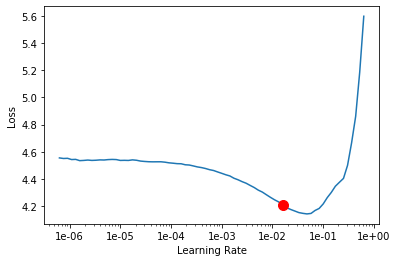

In [16]:
learn.recorder.plot(suggestion=True)

In [17]:
# weights 0.7 0.1 0.2 with rotate(10),no lighting and no cutout, zoom 1.1
lr = 1e-2
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,1.418144,0.882067,0.570923,0.852706,0.726223,0.680194,11:52
1,0.926873,0.495665,0.772006,0.912756,0.836317,0.823271,10:57
2,0.720021,0.366382,0.827680,0.939966,0.906909,0.875559,10:53
3,0.580855,0.288991,0.877711,0.955854,0.930578,0.910463,10:56
4,0.513095,0.269618,0.884433,0.954953,0.943583,0.916851,10:56


In [18]:
learn.save('res34-stage1-pretrained-712') # use it as pre-trained res34 model

In [19]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-06
Min loss divided by 10: 4.79E-07


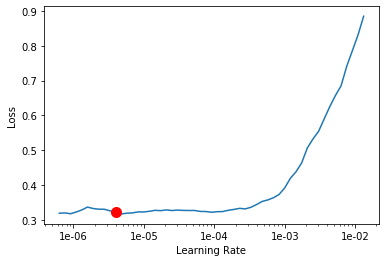

In [22]:
learn.recorder.plot(suggestion=True)

In [20]:
learn.fit_one_cycle(15,slice(1e-6,lr/5))

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,0.508303,0.268843,0.881558,0.957374,0.943898,0.916097,13:18
1,0.503102,0.262509,0.884260,0.955950,0.949669,0.918535,13:18
2,0.484213,0.257836,0.894631,0.956744,0.942585,0.922148,13:19
3,0.490407,0.250645,0.896045,0.956843,0.948700,0.924408,13:20
4,0.475706,0.244204,0.891908,0.959625,0.951422,0.923716,13:20
5,0.459323,0.232679,0.898197,0.961644,0.960155,0.929548,13:21
6,0.442722,0.228136,0.901789,0.960504,0.952455,0.929134,13:20
7,0.421150,0.218326,0.906428,0.964267,0.954299,0.932856,13:21
8,0.403666,0.213400,0.905010,0.963162,0.956771,0.932488,13:21
9,0.390811,0.205533,0.912880,0.965360,0.954240,0.936340,13:20


In [23]:
learn.fit_one_cycle(10,slice(1e-5/2,lr/5))

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,0.317118,0.270335,0.879492,0.957281,0.950476,0.916685,13:12
1,0.285154,0.248343,0.889867,0.959840,0.941218,0.920198,13:10
2,0.273177,0.226586,0.898027,0.959028,0.955282,0.927591,13:11
3,0.234386,0.210849,0.907131,0.961403,0.955206,0.932718,13:07
4,0.191108,0.195052,0.913447,0.967579,0.957751,0.938056,13:06
5,0.165866,0.186090,0.919658,0.968590,0.963550,0.942864,13:06
6,0.152138,0.182373,0.921901,0.968069,0.967486,0.944839,13:07
7,0.117514,0.179024,0.924455,0.970505,0.966549,0.946491,13:12
8,0.113998,0.178479,0.924086,0.971992,0.965019,0.946296,13:07
9,0.109961,0.177174,0.925311,0.972214,0.964652,0.946872,13:07


In [24]:
learn.save('resnet-stage-2-712')